# Tracks of ARs in ERA5
### Get masks of ARs, remap to healpix
### Get HRRR data, remap to healpix
### Apply mask to HRRR data
### Create histogram of variables within the mask

Lexie Goldberger
05/12/25

Help from:
- Bryce Harrop, PNNL
- Zhe Feng, PNNL
- https://easy.gems.dkrz.de/Processing/healpix/lonlat_remap.html
- https://mesowest.utah.edu/html/hrrr/

In [3]:
import s3fs
import xarray as xr
import pandas as pd
import numpy as np
import os
import pyproj
import intake
from easygems import healpix as egh
import matplotlib.pyplot as plt
import metpy
import datetime
import cartopy.crs as ccrs
from functools import partial
import healpy
import zarr
import numcodecs
import gc
import warnings
warnings.filterwarnings('ignore')

## 1) Read in mask
Generated by Bryce Harrop

In [30]:
# Get file
root_dir = '/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/'
in_mask_dir = f'{root_dir}scream2D_ne120_hp8_fast.ar_filtered_nodes.for_Lexie.nc'
print(in_mask_dir)

/pscratch/sd/b/beharrop/kmscale_hackathon/hackathon_pre/scream2D_ne120_hp8_fast.ar_filtered_nodes.nc


In [32]:
# Open file
dshp_ar = xr.open_dataset(in_mask_dir)
dshp_ar

<xarray.Dataset> Size: 189MB
Dimensions:        (time: 240, cell: 786432, crs: 0)
Coordinates:
  * time           (time) object 2kB 2019-08-13 12:00:00 ... 2019-09-12 09:00:00
  * crs            (crs) float64 0B 
Dimensions without coordinates: cell
Data variables:
    AR_binary_tag  (time, cell) int8 189MB ...
Attributes: (12/24)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          3
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel
    NCO:                          netCDF Operators version 5.3.2 (Homepage = ...
    history_of_appended_files:    Mon May 12 12:42:15 2025: Appended file crs...
    history:                      Mon May 12 12:43:07 2025: ncrename -d ncol,...

<Figure size 640x480 with 0 Axes>

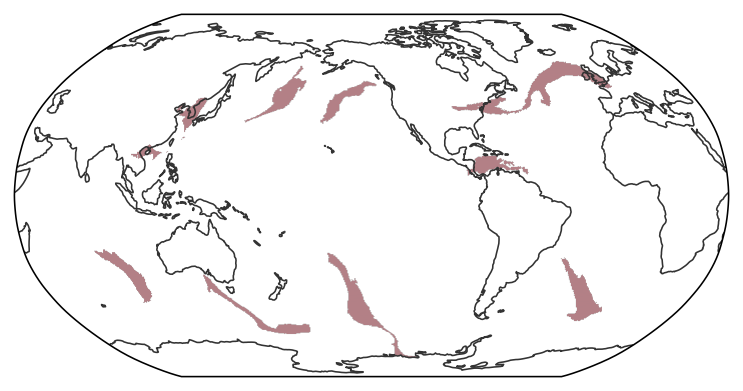

In [39]:
# Plot atmospheric river mask
temp = dshp_ar['AR_binary_tag'].sel(time='2019-08-14T12:00:00').squeeze()
egh.healpix_show(temp.where(temp>0), cmap='Reds_r', dpi=144, alpha=0.5)

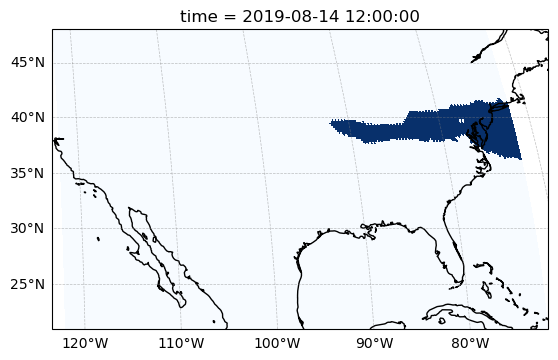

In [48]:
# Plot CONUS only
def get_zoom_level(ds):
    number = ds.crs.healpix_nside
    return int(math.log2(number))

def get_nn_lon_lat_index(nside, lons, lats):
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        healpy.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

# get_nn_lon_lat_index(2, np.linspace(-180, 180, 800), np.linspace(-90, 90, 400)).plot(figsize=(8, 4))

zoom = get_zoom_level(dshp_ar)

# CONUS
lon_min = -122
lon_max = -72
lat_min = 21
lat_max = 48
idx = get_nn_lon_lat_index(2**zoom, np.linspace(lon_min, lon_max, 300), np.linspace(lat_min, lat_max, 300))

ds_lon_lat = dshp_ar['AR_binary_tag'].sel(time='2019-08-14T12:00:00').isel(cell=idx)

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ds_lon_lat.plot(cmap = 'Blues',transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [57]:
%%time
# Get times when AR present in CONUS
 
ds = dshp_ar
var = 'AR_binary_tag'

# Assume ds is your dataset, 'var' is the variable, and idx is your cell index
selected_times = []

for t in range(ds.dims['time']):
    ds_var = ds[var].isel(time=t, cell=idx)
    if ds_var.values.max() == 1:
        selected_times.append(ds['time'].isel(time=t).item())
        if len(selected_times) == 5:
            break # stop loop after 5 ARs are found to save time

[cftime.DatetimeNoLeap(2019, 8, 14, 9, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2019, 8, 14, 12, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2019, 8, 14, 15, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2019, 8, 14, 18, 0, 0, 0, has_year_zero=True), cftime.DatetimeNoLeap(2019, 8, 15, 0, 0, 0, 0, has_year_zero=True)]
CPU times: user 10.5 s, sys: 76.6 ms, total: 10.6 s
Wall time: 10.6 s


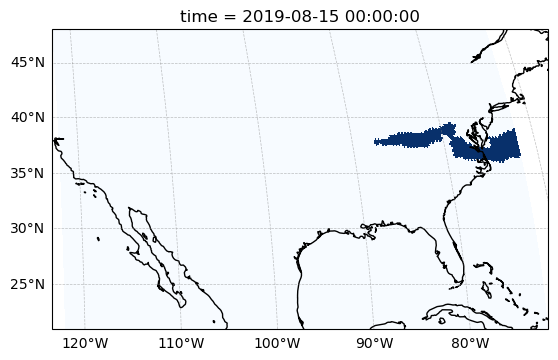

In [58]:
# Plot one of the selected times to check
ds_lon_lat = dshp_ar['AR_binary_tag'].sel(time=selected_times[-1]).isel(cell=idx)

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ds_lon_lat.plot(cmap = 'Blues',transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# 2) Get HRRR data in ZARR for selected times identified
We're interested in surface wind speed data

You'll need to convert to lat/lon

Files found here: https://hrrrzarr.s3.amazonaws.com/index.html

In [89]:
# Edit for variable you want
level = 'surface'
param_short_name = 'GUST'

In [82]:
# Get HRRR Data only for times when AR detected in CONUS

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

s3 = s3fs.S3FileSystem(anon=True)
def lookup(path):
    return s3fs.S3Map(path, s3=s3)
    
def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds
def load_combined_dataset(selected_times, level, param_short_name):
    combined_ds = None
    for ts in selected_times:
        time = ts
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

# GET DATA
dshrrr = load_combined_dataset(selected_times, level, param_short_name)
# dshrrr.isel(time=0).param_short_name.plot()

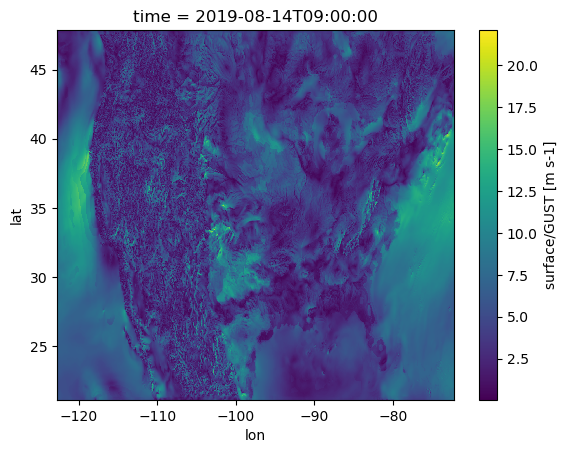

In [90]:
# Convert to latitude and longitude

def HRRR_projection_to_latlon(ds, variable):
    da = ds[variable]
    # Extract and rename 1D coordinates
    lat_1d = xr.DataArray(da['latitude'][:, 0].values, dims='latitude')
    lon_1d = xr.DataArray(da['longitude'][0, :].values, dims='longitude')
    
    # Create a new DataArray with dimensions (latitude, longitude)
    new_da = xr.DataArray(
        data=da.values,
        dims=('time','latitude', 'longitude'),
        coords={
            'time': da.time,
            'latitude': lat_1d,
            'longitude': lon_1d
            
        },
        attrs=da.attrs
    )
    new_da = new_da.rename({'latitude': 'lat', 'longitude': 'lon'})
    return new_da

# DO CONVERSION
dshrrr = HRRR_projection_to_latlon(dshrrr, param_short_name)
dshrrr.isel(time=0).plot()

In [93]:
# Make a flag for mask longitude sign
signed_lon = True if np.min(dshrrr.lon) < 0 else False
print(f"Dataset lon coordinate has negative values: {signed_lon}")

Dataset lon coordinate has negative values: True


# 3) Regrid HRRR data to Healpix
HRRR dataset has resolution of 3km, therefore need to map to data with similar resolution. I'm going to use scream data with 6km resolution

In [95]:
# List available catalogs
catalog_file = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
# Select a catalog for your location
current_location = "NERSC"
cat = intake.open_catalog(catalog_file)[current_location]

In [102]:
%%time
# Get zoom level from catalog
highest_zoom_level = pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"]).allowed.max()[0]
catalog_params = {'zoom': highest_zoom_level}  # Can have multiple parameters

# Note the use of **catalog_params to pass the parameters
ds_hp = cat['scream2D_hrly'](**catalog_params).to_dask()

# Add lat/lon coordinates to the DataSet.
# Set signed_lon=True for matching lat/lon DataSet with longitude -180 to +180
ds_hp = ds_hp.pipe(partial(egh.attach_coords,signed_lon=signed_lon))

# Assign extra coordinates (lon_hp, lat_hp) to the HEALPix coordinates
# This is needed for limiting the extrapolation during remapping
lon_hp = ds_hp.lon.assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = ds_hp.lat.assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)

CPU times: user 892 ms, sys: 326 ms, total: 1.22 s
Wall time: 1.42 s


In [104]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon", roll=False):
    """
    Fix coordinates in a dataset:
    1. Convert longitude from -180/+180 to 0-360 range (optional)
    2. Roll dataset to start at longitude 0 (optional)
    3. Ensure coordinates are in ascending order
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with lat/lon coordinates
    lat_dim : str, optional
        Name of latitude dimension, default "lat"
    lon_dim : str, optional
        Name of longitude dimension, default "lon"
    roll : bool, optional, default=False
        If True, convert longitude from -180/+180 to 0-360, and roll the dataset to start at longitude 0
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with fixed coordinates
    """
    if roll:
        # Find where longitude crosses from negative to positive (approx. where lon=0)
        lon_0_index = (ds[lon_dim] < 0).sum().item()
        
        # Create indexers for the roll
        lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
        
        # Roll dataset and convert longitudes to 0-360 range
        ds = ds.isel({lon_dim: lon_indices})
        lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
        ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds

def calculate_healpix_tolerance(zoom_level):
    """
    Calculate appropriate tolerance for is_valid function based on HEALPix zoom level.
    Returns approximately one grid cell size in degrees.
    
    Args:
        zoom_level (int): HEALPix zoom level
        
    Returns:
        float: Tolerance in degrees
    """
    # Calculate nside from zoom level (nside = 2^zoom)
    # nside determines HEALPix resolution - each increase in zoom doubles the resolution
    nside = 2 ** zoom_level
    
    # Calculate approximate pixel size in degrees
    # Mathematical derivation:
    # - Sphere has total area of 4π steradians (= 4π × (180/π)² sq. degrees)
    # - HEALPix divides sphere into 12 × nside² equal-area pixels
    # - Each pixel has area = 4π × (180/π)² / (12 × nside²) sq. degrees
    # - Linear size = √(pixel area) ≈ 58.6 / nside degrees
    # This gives approximately the angular width of one HEALPix cell
    pixel_size_degrees = 58.6 / nside
    
    return pixel_size_degrees # tolerance


def is_valid(ds, tolerance):
    """
    Limit extrapolation distance to a certain tolerance.
    This is useful for preventing extrapolation of regional data to global HEALPix grid.

    Args:
        ds (xarray.Dataset):
            The dataset containing latitude and longitude coordinates.
        tolerance (float): default=0.1
            The maximum allowed distance in [degrees] for extrapolation.

    Returns:
        xarray.DataSet.
    """
    return (np.abs(ds.lat - ds.lat_hp) < tolerance) & (np.abs(ds.lon - ds.lon_hp) < tolerance)

In [114]:
%%time
# Remap mask DataSet to HEALPix
tolerance = calculate_healpix_tolerance(highest_zoom_level)
ds_HRRR_hp = dshrrr.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=tolerance))
# Drop unnecessary coordinates
ds_HRRR_hp = ds_HRRR_hp.drop_vars(["lat_hp", "lon_hp","lon","lat"])

CPU times: user 2.54 s, sys: 3.35 s, total: 5.89 s
Wall time: 5.92 s


In [136]:
# Convert DataArray to Dataset
ds_HRRR_hp = xr.Dataset({"GUST": ds_HRRR_hp})
ds_HRRR_hp["GUST"].attrs["units"] = "m s^-1"
ds_HRRR_hp

<xarray.Dataset> Size: 226MB
Dimensions:  (time: 5, cell: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 40B 2019-08-14T09:00:00 ... 2019-08-15
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
Data variables:
    GUST     (time, cell) float16 126MB nan nan nan nan nan ... nan nan nan nan

<Figure size 640x480 with 0 Axes>

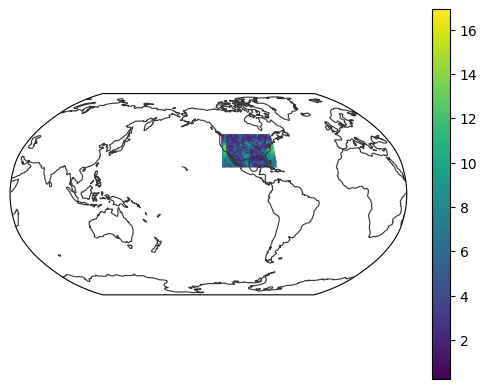

In [139]:
img = egh.healpix_show(ds_HRRR_hp['GUST'].isel(time=0))
plt.colorbar(img)
plt.title(str(ds_HRRR_hp.time[0]))

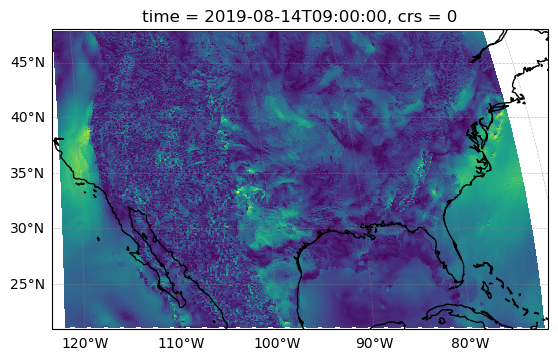

In [120]:
zoom = get_zoom_level(ds_HRRR_hp)

# CONUS
idx = get_nn_lon_lat_index(2**zoom, np.linspace(lon_min, lon_max, 300), np.linspace(lat_min, lat_max, 300))

ds_lon_lat = ds_HRRR_hp['GUST'].isel(time=0,cell=idx)

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ds_lon_lat.plot(transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# 4) Reduce resolution to zoom level 8
Doing this to match AR mask

In [142]:
ds_HRRR_hp

<xarray.Dataset> Size: 226MB
Dimensions:  (time: 5, cell: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 40B 2019-08-14T09:00:00 ... 2019-08-15
    crs      int64 8B 0
  * cell     (cell) int64 101MB 0 1 2 3 ... 12582908 12582909 12582910 12582911
Data variables:
    GUST     (time, cell) float16 126MB nan nan nan nan nan ... nan nan nan nan

In [151]:
# Single Precision for Floats

def get_dtype(da):
    if np.issubdtype(da.dtype, np.floating):
        return "float32"
    else:
        return da.dtype
    
    
# Chunking (note, 'cell' has to match name of column dimension in input)

def get_chunks(dimensions):
    if "level" in dimensions:
        chunks = {
            "time": 24,
            "cell": 4**5,
            "level": 4,
        }
    else:
        chunks = {
            "time": 24,
            "cell": 4**6,
        }

    return tuple((chunks[d] for d in dimensions))

# Compression

def get_compressor():
    return numcodecs.Blosc("zstd", shuffle=2)

#Loop over all variables and create encoding directory...

def get_encoding(dataset):
    return {
        var: {
            "compressor": get_compressor(),
            "dtype": get_dtype(dataset[var]),
            "chunks": get_chunks(dataset[var].dims),
        }
        for var in dataset.variables
        if var not in dataset.dims
    }

In [147]:
out_dir = '/pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/'
version = 'v1'

In [159]:
%%time
# Now Loop (max memory is still 25GB for zoom =7 Not using dask right or the assigment should be different...)
dn = ds_HRRR_hp
for x in range(9,-1,-1):
    s = str(x)
    # ofn = "scream_ne1024_all_hp"+s+"_v6.zarr"
    ofn = f"{out_dir}_all_hp{s}_{version}.zarr"
    # Coarsen the dataset
    dx = dn.coarsen(cell=4).mean()
    # Update HEALPix level metadata
    dx['crs'].attrs['healpix_nside'] = 2**int(s)
    # Write to Zarr
    store = zarr.storage.DirectoryStore(ofn, dimension_separator="/")
    try:
        dx.chunk({"time": 24, "cell": -1}).to_zarr(store, encoding=get_encoding(dx))
        print(f"✓ Wrote to: {ofn}")
    except:
        pass
    # Update dataset with the new coarsened data
    dn = dx
    del dx,store
    gc.collect()

✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp7_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp6_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp5_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp4_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp3_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp2_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp1_v1.zarr
✓ Wrote to: /pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/_all_hp0_v1.zarr
CPU times: user 8.07 s, sys: 988 ms, total: 9.06 s
Wall time: 10.2 s


# 5) Load in HRRR data at zoom level 8 and mask with AR mask

In [161]:
out_dir = '/pscratch/sd/l/lexberg/hackathon2025/HRRR_hpZARR_data/'
filename = '_all_hp8_v1.zarr'
dataset = xr.open_zarr(os.path.join(out_dir, filename))
dataset

<xarray.Dataset> Size: 22MB
Dimensions:  (time: 5, cell: 786432)
Coordinates:
  * cell     (cell) float64 6MB 7.5 23.5 39.5 ... 1.258e+07 1.258e+07 1.258e+07
    crs      int64 8B ...
  * time     (time) datetime64[ns] 40B 2019-08-14T09:00:00 ... 2019-08-15
Data variables:
    GUST     (time, cell) float32 16MB dask.array<chunksize=(5, 4096), meta=np.ndarray>

In [195]:
number = get_zoom_level(dataset)
print(f"The zoom level of the HRRR loaded dataset is {number}")

number = get_zoom_level(dshp_ar)
print(f"The zoom level of the AR mask loaded dataset is {number}")

The zoom level of the HRRR loaded dataset is 8
The zoom level of the AR mask loaded dataset is 8


<Figure size 640x480 with 0 Axes>

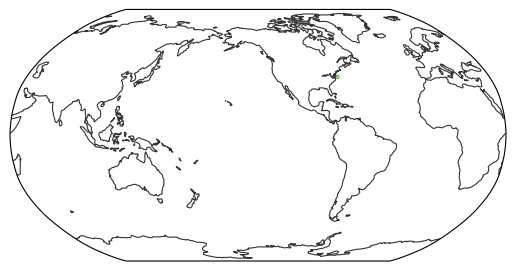

In [200]:
t = selected_times[-1]
ts = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)

ds_data = dataset["GUST"].sel(time = str(ts))
ds_mask = dshp_ar['AR_binary_tag'].sel(time= str(ts))
masked = ds_data.where(ds_mask > 0.5).squeeze()

img2 = egh.healpix_show(masked)

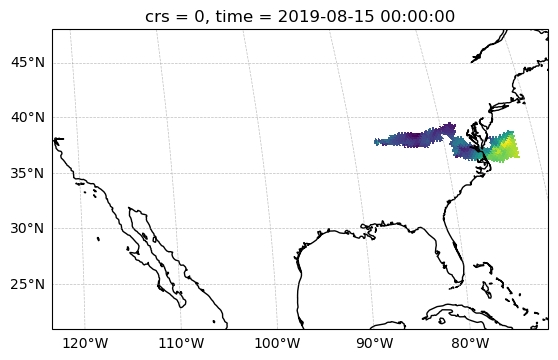

In [201]:
zoom = get_zoom_level(ds_data)

# CONUS
lon_min = -122
lon_max = -72
lat_min = 21
lat_max = 48
idx = get_nn_lon_lat_index(2**zoom, np.linspace(lon_min, lon_max, 300), np.linspace(lat_min, lat_max, 300))

ds_lon_lat = masked.isel(cell=idx)

fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ds_lon_lat.plot(transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

In [222]:
# Store results in a list or dictionary, depending on your use case
masked_results = []

for t in selected_times:
    ts = datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second)
    print(ts)
    ds_data = dataset["GUST"].sel(time=str(ts))
    ds_mask = dshp_ar['AR_binary_tag'].sel(time=str(ts))
    
    masked = ds_data.where(ds_mask > 0.5).squeeze()
    masked_results.append(masked)

masked_combined = xr.concat(masked_results, dim='time')
masked_combined['time'] = selected_times

2019-08-14 09:00:00
2019-08-14 12:00:00
2019-08-14 15:00:00
2019-08-14 18:00:00
2019-08-15 00:00:00


# 6) Perform Analysis
Plot histogram of masked area

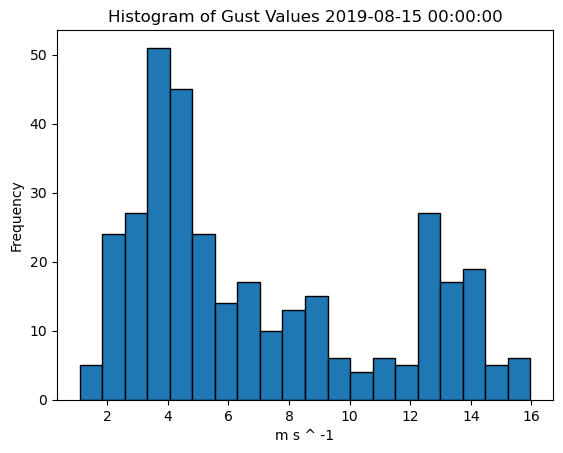

In [205]:
# masked is an numpy.ndarray
data = masked.values
AR = data[~np.isnan(data)]
AR
# Plot histogram
plt.hist(AR, bins=20, edgecolor='black')
plt.title(f"Histogram of Gust Values {ts}")
plt.xlabel("m s ^ -1")
plt.ylabel("Frequency")
plt.show()

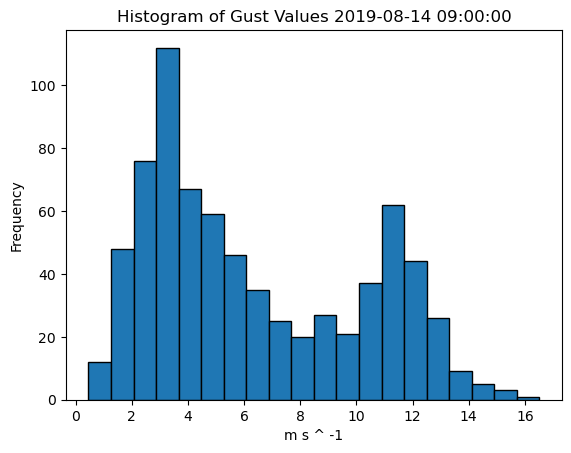

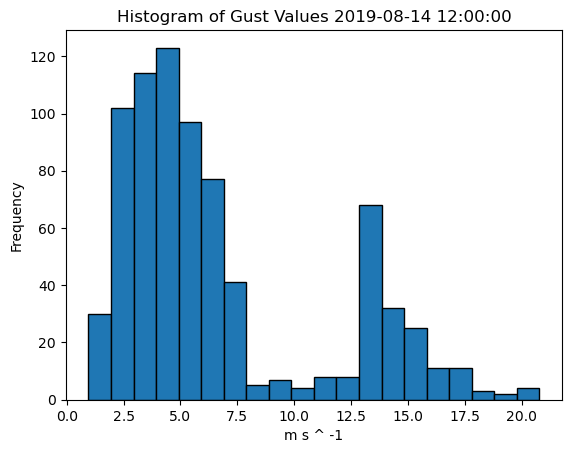

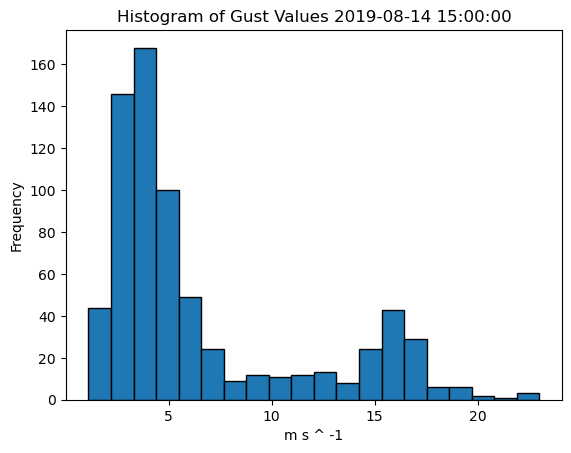

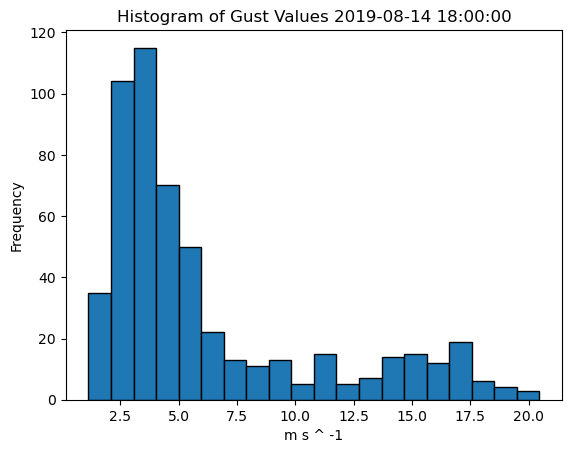

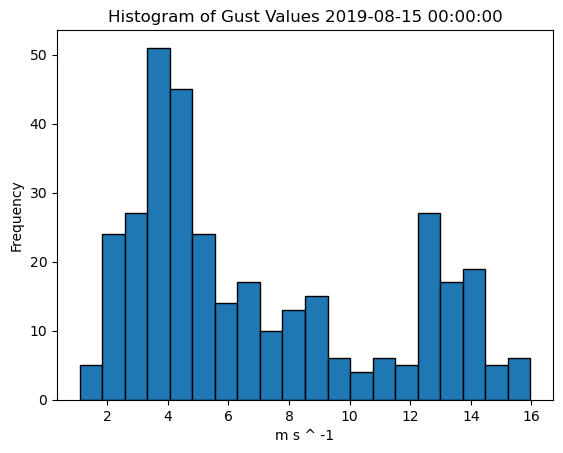

In [225]:
for t in masked_combined.time.values:
    # Select data for the current time
    masked = masked_combined.sel(time=t)
    data = masked.values
    
    # Filter out NaNs
    AR = data[~np.isnan(data)]
    
    # Skip if all data is NaN
    if AR.size == 0:
        continue

    # Plot histogram
    plt.figure()
    plt.hist(AR, bins=20, edgecolor='black')
    plt.title(f"Histogram of Gust Values {str(t)}")
    plt.xlabel("m s ^ -1")
    plt.ylabel("Frequency")
    plt.show()

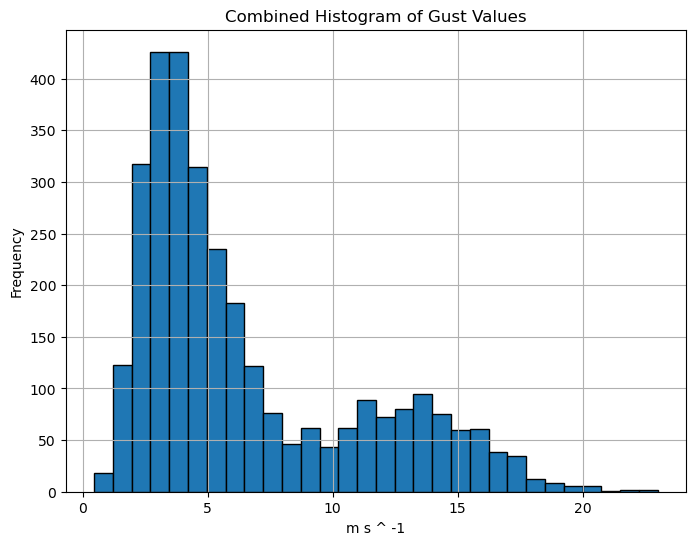

In [226]:
# Flatten all values into one array and remove NaNs
all_data = masked_combined.values.flatten()
all_data = all_data[~np.isnan(all_data)]

# Check if there's any data to plot
if all_data.size > 0:
    plt.figure(figsize=(8, 6))
    plt.hist(all_data, bins=30, edgecolor='black')
    plt.title("Combined Histogram of Gust Values")
    plt.xlabel("m s ^ -1")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No valid data available for histogram.")